In [213]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn import preprocessing

In [214]:
#Load data
df = pd.read_csv('diabetes_dataset.csv')

#Read first few lines
print(df.head())

   year  gender   age location  race:AfricanAmerican  race:Asian  \
0  2020  Female  32.0  Alabama                     0           0   
1  2015  Female  29.0  Alabama                     0           1   
2  2015    Male  18.0  Alabama                     0           0   
3  2015    Male  41.0  Alabama                     0           0   
4  2016  Female  52.0  Alabama                     1           0   

   race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
0               0              0           1             0              0   
1               0              0           0             0              0   
2               0              0           1             0              0   
3               1              0           0             0              0   
4               0              0           0             0              0   

  smoking_history    bmi  hbA1c_level  blood_glucose_level  diabetes  
0           never  27.32          5.0                  10

In [215]:
#Summary statistics
df.describe(include='all')

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,NaN,3,NaN,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,NaN,Female,NaN,Iowa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN
freq,NaN,58552,NaN,2038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN
mean,2018.360820,NaN,41.885856,NaN,0.202230,0.200150,0.198760,0.19888,0.199980,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000
std,1.345239,NaN,22.516840,NaN,0.401665,0.400114,0.399069,0.39916,0.399987,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883
min,2015.000000,NaN,0.080000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000
25%,2019.000000,NaN,24.000000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000
50%,2019.000000,NaN,43.000000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000
75%,2019.000000,NaN,60.000000,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000


From above table we can see data is collected from year 2015 to 2022, between age 0.08 and 80, bmi between 10.01 and 95.69.

Questions:
1. What is the distribution of race?&Can a person have two different races?
2. Trend of diabetes YoY.
3. Relationship between diabetes and other factors(bmi,hypertension,heart disease,hbA1c level, smoking history and bloood glucose level)?
4. Age distribution among different groups(diabetes/smoking)?
5. Location distribution of population.
6. Diabetes distribution in gender?

In [218]:
#Answer Q1
#First is to give each line a Patient ID
df["id"] = df.index
#Add values for all race columns
df["sum_race"] = df[["race:AfricanAmerican","race:Asian","race:Caucasian","race:Hispanic","race:Other"]].sum(axis=1)
df.describe()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes,id,sum_race
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0
mean,2018.360820,41.885856,0.202230,0.200150,0.198760,0.19888,0.199980,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000,49999.500000,1.0
std,1.345239,22.516840,0.401665,0.400114,0.399069,0.39916,0.399987,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883,28867.657797,0.0
min,2015.000000,0.080000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000,0.000000,1.0
25%,2019.000000,24.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000,24999.750000,1.0
50%,2019.000000,43.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000,49999.500000,1.0
75%,2019.000000,60.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000,74999.250000,1.0
max,2022.000000,80.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000,99999.000000,1.0


From race above summary statistics, a person can't have more than 1 race attibute. From mean of different race, we could see the value is around 0.2. Therefore, the race distribution does not align with population race distribution. Sample is not randomly collected from the population.

year  diabetes
2015  0            8001
      1             759
2016  0            7995
      1             765
2018  0            2435
      1             243
2019  0           73018
      1            6727
2020  0              39
      1               3
2021  0               6
      1               1
2022  0               6
      1               2
Name: diabetes, dtype: int64


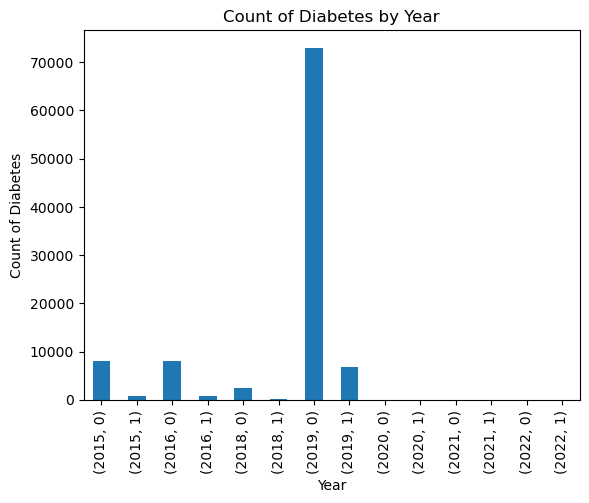

In [220]:
#Answer Q2
#Aggregate data then plot

aggregated_data = df.groupby(['year','diabetes'])['diabetes'].count() 
print(aggregated_data)

aggregated_data.plot(kind='bar')
plt.title('Count of Diabetes by Year')
plt.xlabel('Year')
plt.ylabel('Count of Diabetes')
plt.show()



We can see the diabete patients are not evenly spreaded across the years. We might need to take log transformation of results.

In [222]:
#Answer Q3
# Importing library
import pandas as pd
from scipy.stats import f_oneway

# Separate the data into groups based on the 'Group' column
groups = [df['bmi'][df['diabetes'] == group] for group in df['diabetes'].unique()]

# Perform the ANOVA test
f_statistic, p_value = f_oneway(*groups)

print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 4816.113932175362
P-value: 0.0


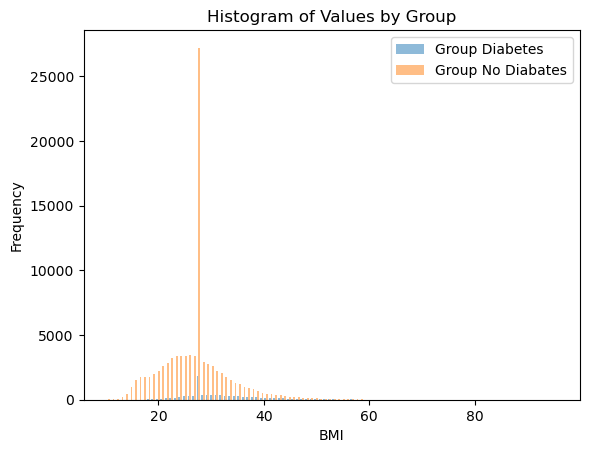

In [223]:

# Plot histograms
plt.hist([df[df['diabetes'] == 1]['bmi'], df[df['diabetes'] == 0]['bmi']], 
         bins=100, alpha=0.5, label=['Group Diabetes', 'Group No Diabates'])
plt.legend()
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Histogram of Values by Group')
plt.show()

In [224]:

# Create bins by group
df['bin'] = df.groupby('diabetes')['bmi'].transform(lambda x: pd.cut(x, bins=50, labels=False))
# Filter dataframe based on bin
filtered_df = df[df['bin'] == 10]
filtered_df.describe()


,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes,id,sum_race,bin
count,32246.000000,32246.000000,32246.000000,32246.000000,32246.000000,32246.000000,32246.000000,32246.000000,32246.000000,32246.000000,32246.000000,32246.000000,32246.000000,32246.000000,32246.0,32246.0
mean,2018.366061,45.075916,0.203746,0.198722,0.195838,0.202785,0.198908,0.060566,0.036191,27.447070,5.496921,137.185449,0.064938,49773.052906,1.0,10.0
std,1.339536,21.291683,0.402789,0.399045,0.396851,0.402080,0.399185,0.238536,0.186767,0.342261,1.050983,39.246310,0.246421,28739.168039,0.0,0.0
min,2015.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.530000,3.500000,80.000000,0.000000,0.000000,1.0,10.0
25%,2019.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.320000,4.800000,100.000000,0.000000,24888.250000,1.0,10.0
50%,2019.000000,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000,49903.500000,1.0,10.0
75%,2019.000000,62.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.320000,6.200000,159.000000,0.000000,74432.250000,1.0,10.0
max,2022.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,28.850000,9.000000,300.000000,1.000000,99991.000000,1.0,10.0


From the histogram above, there was a spike in the plot which signaled there was an abnormal reading for bmi. We discovered that there were many bmi values of 27.32, probably default value. We will need to find out how to deal with this.

In [226]:
#Create a contingency table

contingency_table = pd.crosstab(df['diabetes'], df['smoking_history'])

print(contingency_table)

def perform_chi_square_test(data, col1, col2):
    # Creating a contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # Performing the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Interpreting the result
    significant = p < 0.05  # 5% significance level
    return chi2, p, significant


# Additional aspects to test in the Mathematics dataset
additional_aspects_to_test = {
    'Diabetes and hypertension': ('diabetes', 'hypertension'),
    'Diabetes and heart disease': ('diabetes', 'heart_disease'),
    'Diabetes and smoking history': ('diabetes', 'smoking_history')

}
# Performing the additional tests for Mathematics dataset
additional_mat_chi_square_results = {aspect: perform_chi_square_test(df, *columns) for aspect, columns in additional_aspects_to_test.items()}
additional_mat_chi_square_results

smoking_history  No Info  current  ever  former  never  not current
diabetes                                                           
0                  34362     8338  3532    7762  31749         5757
1                   1454      948   472    1590   3346          690


{'Diabetes and hypertension': (3910.708546826595, 0.0, True),
 'Diabetes and heart disease': (2945.847521829186, 0.0, True),
 'Diabetes and smoking history': (1956.0944200848764, 0.0, True)}

Clearly there is a relationship between hypertension and diabetes. There is also a relationship between heart disease and diabetes.

In [228]:
#Answer Q3
# Importing library
import pandas as pd
from scipy.stats import f_oneway

# Separate the data into groups based on the 'Group' column
groups = [df['hbA1c_level'][df['diabetes'] == group] for group in df['diabetes'].unique()]

# Perform the ANOVA test
f_statistic, p_value = f_oneway(*groups)

print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 19122.2111838759
P-value: 0.0


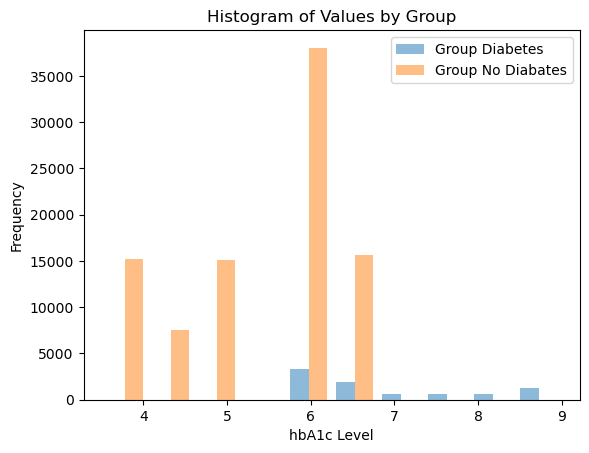

In [229]:
# Plot histograms
plt.hist([df[df['diabetes'] == 1]['hbA1c_level'], df[df['diabetes'] == 0]['hbA1c_level']], 
         bins=10, alpha=0.5, label=['Group Diabetes', 'Group No Diabates'])
plt.legend()
plt.xlabel('hbA1c Level')
plt.ylabel('Frequency')
plt.title('Histogram of Values by Group')
plt.show()

There is a strong relationship between hbA1c level and diabetes.

In [231]:
# Separate the data into groups based on the 'Group' column
groups = [df['blood_glucose_level'][df['diabetes'] == group] for group in df['diabetes'].unique()]

# Perform the ANOVA test
f_statistic, p_value = f_oneway(*groups)

print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 21363.054361421557
P-value: 0.0


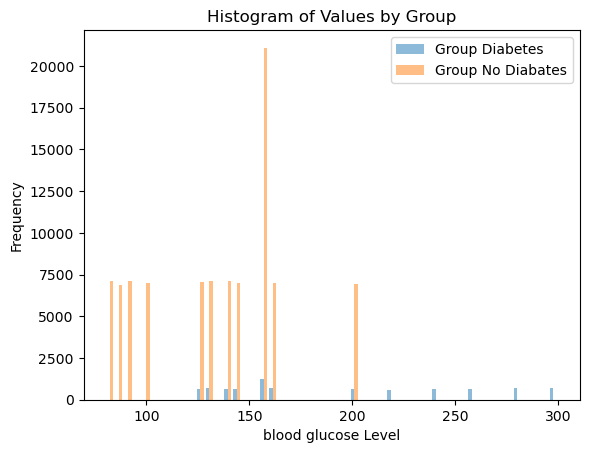

In [232]:
# Plot histograms
plt.hist([df[df['diabetes'] == 1]['blood_glucose_level'], df[df['diabetes'] == 0]['blood_glucose_level']], 
         bins=50, alpha=0.5, label=['Group Diabetes', 'Group No Diabates'])
plt.legend()
plt.xlabel('blood glucose Level')
plt.ylabel('Frequency')
plt.title('Histogram of Values by Group')
plt.show()

There is a relationship between blood glucose level and diabetes.

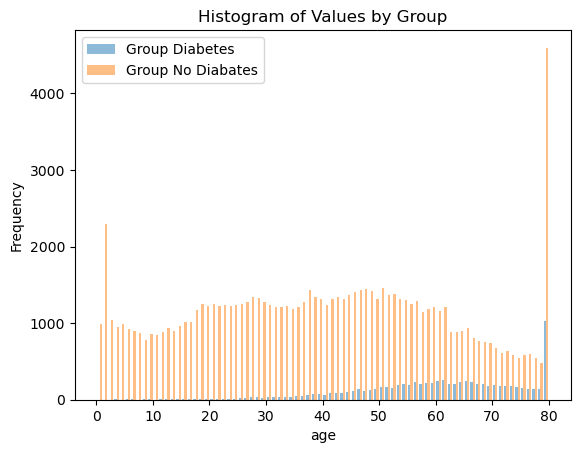

In [234]:
# Plot histograms
plt.hist([df[df['diabetes'] == 1]['age'], df[df['diabetes'] == 0]['age']], 
         bins=80, alpha=0.5, label=['Group Diabetes', 'Group No Diabates'])
plt.legend()
plt.xlabel('age')
plt.ylabel('Frequency')
plt.title('Histogram of Values by Group')
plt.show()

We found that the older you are, the more likely you'll get diabetes. If you are 20 or younger, then there is no chance you'll have diabetes.

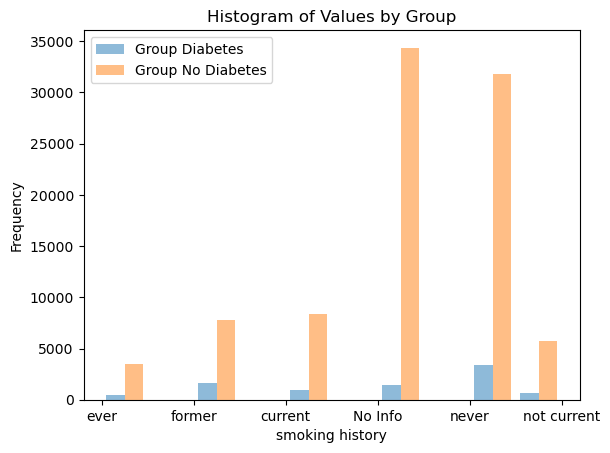

In [236]:
# Plot histograms
plt.hist([df[df['diabetes'] == 1]['smoking_history'], df[df['diabetes'] == 0]['smoking_history']], 
         bins=10, alpha=0.5, label=['Group Diabetes', 'Group No Diabetes'])
plt.legend()
plt.xlabel('smoking history')
plt.ylabel('Frequency')
plt.title('Histogram of Values by Group')
plt.show()

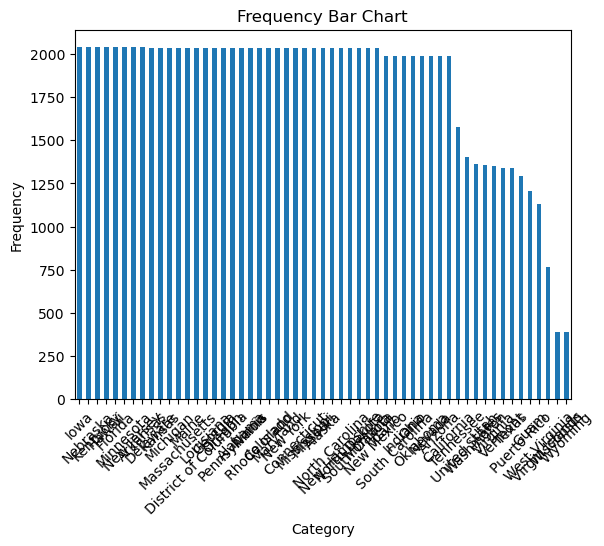

In [237]:
#Frequency plot for patients from different state
frequency = df['location'].value_counts()
frequency.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Frequency Bar Chart')
plt.xticks(rotation=45)
plt.show()

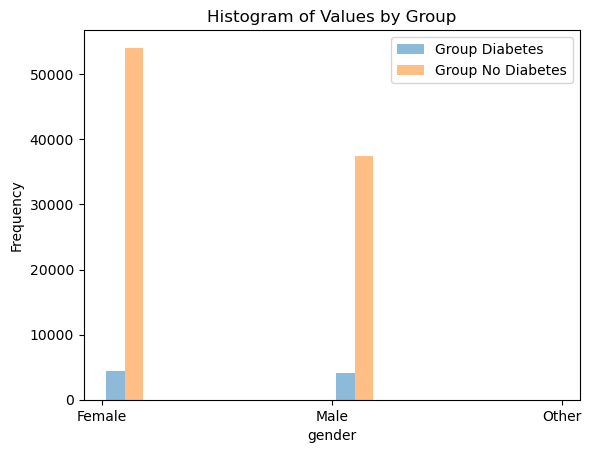

In [238]:
# Plot histograms
plt.hist([df[df['diabetes'] == 1]['gender'], df[df['diabetes'] == 0]['gender']], 
         bins=10, alpha=0.5, label=['Group Diabetes', 'Group No Diabetes'])
plt.legend()
plt.xlabel('gender')
plt.ylabel('Frequency')
plt.title('Histogram of Values by Group')
plt.show()

In [239]:
#Convert into dummy variables
df = pd.get_dummies(df, columns=['gender'], drop_first=True)
df = pd.get_dummies(df, columns=['location'], drop_first=True)
df = pd.get_dummies(df, columns=['smoking_history'], drop_first=True)
#Separate data into training and testing


# Assuming X is your feature data and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [240]:
#Normalizing data
X_train_normalized = preprocessing.normalize(X_train, norm='l2')
X_test_normalized = preprocessing.normalize(X_test, norm='l2')

In [320]:
#Select features using RFE
data_final_vars=df.columns.values.tolist()
y=['diabetes']
X=[i for i in data_final_vars if i not in y]

logreg = LogisticRegression()
rfe = RFE(logreg, step=10,n_features_to_select=10)
rfe = rfe.fit(X_train_normalized, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
print(X)

[ True  True False False False False False  True  True  True  True  True
  True False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False]
[1 1 5 3 4 3 2 1 1 1 1 1 1 3 1 2 7 3 2 4 8 4 7 3 3 5 5 3 6 3 3 8 4 4 4 7 8
 5 4 7 7 5 5 4 7 7 5 8 6 4 6 6 5 4 8 6 7 5 6 6 5 7 8 8 6 8 6 8 6 7 8 2 2 1
 2 3]
['year', 'age', 'race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other', 'hypertension', 'heart_disease', 'bmi', 'hbA1c_level', 'blood_glucose_level', 'id', 'sum_race', 'bin', 'gender_Male', 'gender_Other', 'location_Alaska', 'location_Arizona', 'location_Arkansas', 'location_California', 'location_Colorado', 'location_Connecticut', 'location_Delaw

In [328]:
#Create a list of features for modeling
true_false_list = rfe.support_
values_list =data_final_vars

result_list = [value for is_true, value in zip(true_false_list, values_list) if is_true]
result_list.remove('diabetes')
print(result_list)


['year', 'age', 'hypertension', 'heart_disease', 'bmi', 'hbA1c_level', 'blood_glucose_level', 'sum_race', 'smoking_history_ever']


In [330]:
#Start with logistic regression

logit_model=sm.Logit(y_train,X_train[result_list].astype(float))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.114221
         Iterations 10
                           Results: Logit
Model:                Logit             Method:            MLE       
Dependent Variable:   diabetes          Pseudo R-squared:  0.607     
Date:                 2024-12-09 16:19  AIC:               18293.3872
No. Observations:     80000             BIC:               18376.9952
Df Model:             8                 Log-Likelihood:    -9137.7   
Df Residuals:         79991             LL-Null:           -23258.   
Converged:            1.0000            LLR p-value:       0.0000    
No. Iterations:       10.0000           Scale:             1.0000    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
---------------------------------------------------------------------
year                 -0.0158   0.0146 -1.0888 0.2762  -0.0444  0.0127
age            

In [243]:
print(df.dtypes)

year                             int64
age                            float64
race:AfricanAmerican             int64
race:Asian                       int64
race:Caucasian                   int64
                                ...   
smoking_history_current           bool
smoking_history_ever              bool
smoking_history_former            bool
smoking_history_never             bool
smoking_history_not current       bool
Length: 77, dtype: object


In [244]:
np.asarray(X_train)

array([[2019, 21.0, 0, ..., False, False, False],
       [2019, 32.0, 0, ..., False, False, False],
       [2019, 58.0, 0, ..., False, True, False],
       ...,
       [2019, 26.0, 0, ..., False, True, False],
       [2019, 5.0, 0, ..., False, False, False],
       [2019, 2.0, 0, ..., False, False, False]], dtype=object)

In [245]:
print(y_test)

75721    0
80184    0
19864    1
76699    0
92991    0
        ..
32595    0
29313    0
37862    0
53421    0
42410    0
Name: diabetes, Length: 20000, dtype: int64


In [246]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

In [247]:
print(diabetes)

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990749, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06833155, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286131, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04688253,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452873, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00422151,  0.00306441]]), 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
        69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
        68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
        87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
       259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
  